# 準備
## インポート等

In [1]:
%matplotlib inline

#ライブラリのインポート
import pandas as pd
import numpy as np

#時間軸の処理用ライブラリ
import datetime as dt

#scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# プロット用
import matplotlib.pyplot as plt

In [2]:
#pandasオプション
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 20)

## ディレクトリの定義

In [3]:
#結果の保存先ディレクトリ
save = 'result/xxx/'

## データの読み込み

In [4]:
#訓練データ（気象データ）の読み込み
x_raw_data = pd.read_csv('data/weather.csv')
x_raw_data.columns = ['date', 'temp', 'temp_high', 'temp_low', 'prec', 'wind', 'sunlight', 'snow']
x_raw_data['date'] = pd.to_datetime(x_raw_data['date'])

In [5]:
#targetの読み込み
y_raw_data = pd.read_csv('data/target.csv')
y_raw_data['date'] = pd.to_datetime(y_raw_data['date'])

# 前処理
## targetの処理

### 欠損値処理

In [6]:
#targetの欠損値補完（線形補完）
y_data = y_raw_data.interpolate()

### 処理済データの確認（可視化）

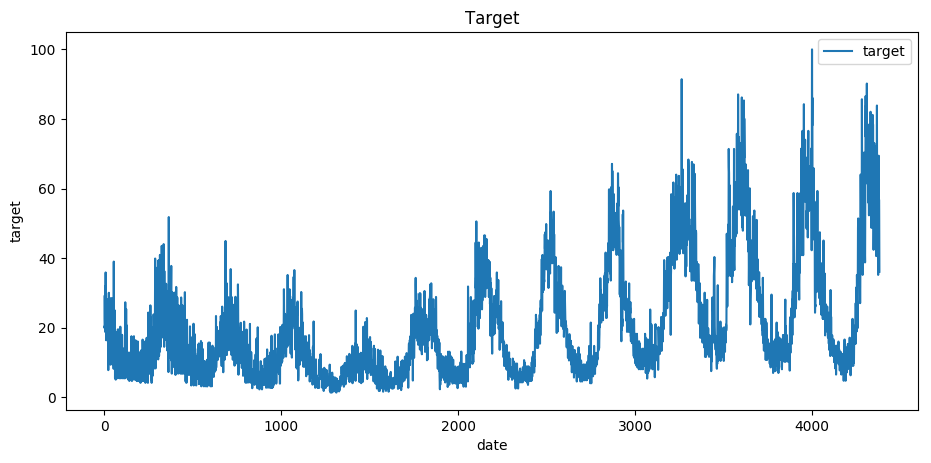

In [7]:
#targetの確認
plt.figure(figsize=(11,5), dpi=100)
y = np.array(y_data['target'])
plt.plot(y, '-', label='target')
plt.title('Target')
plt.xlabel('date')
plt.ylabel('target')
plt.legend()
plt.show()

### y_train, y_testの作成

In [8]:
#y_train, y_testの作成
y_train = np.array(y_data.loc[:4017, 'target'])
y_test = np.array(y_data.loc[4018:, 'target'])

In [9]:
#targetのshapeを確認
print(y_train.shape)
print(y_test.shape)

(4018,)
(365,)


## 特徴量の処理
### データの確認

In [10]:
#特徴量の確認
x_raw_data = x_raw_data.interpolate()
x_raw_data.head()

,date,temp,temp_high,temp_low,prec,wind,sunlight,snow
0,2005-12-01,9.8,12.5,7.2,0.0,3.2,7.5,0
1,2005-12-02,10.5,15.9,5.6,0.0,2.4,4.5,0
2,2005-12-03,8.4,10.8,5.9,0.0,3.2,4.4,0
3,2005-12-04,6.8,8.4,4.9,3.5,2.8,0.0,0
4,2005-12-05,7.9,12.2,3.9,0.0,3.2,9.1,0


### 仮説に基づく処理の実装

In [11]:
#仮説2：日毎の平均気温を系列データとして持つ
#tempをそのまま利用できるためスキップ

#仮説3：日毎の平均気温の対数差分系列を持つ
def logdiff(x_train):
    x_train['temp_log'] = (x_train['temp'] + 5).apply(np.log)
    x_train['temp_log_diff'] = pd.DataFrame(x_train['temp_log'].diff())
    x_train.drop(['temp_log'], axis=1, inplace=True)
    return x_train

#仮説4：日毎の最高気温と最低気温の差を系列データとして持つ
def temprapid(x_train):
    x_train['temp_rapid'] = x_train['temp_high'] - x_train['temp_low']
    x_train.drop(['temp_high', 'temp_low'], axis=1, inplace=True)
    return x_train

#仮説5：曜日の情報をOne-Hot表現で持つ
def week(x_train):
    i = 0
    
    for week in ['mon', 'tue', 'wed', 'thu', 'fri', 'sat']:
        x_train[week] = 0
        x_train.loc[x_train['date'].dt.dayofweek == i, week] = 1
        i += 1
    return x_train

#仮説6：月の情報をOne-Hot表現で持つ
def month(x_train):
    i = 1
    x_train['month'] = x_train['date'].map(lambda x: x.month)
    
    for month in ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov']:
        x_train[month] = 0
        x_train.loc[x_train['month'] == i, month] = 1
        i += 1
    return x_train

#仮説7：日毎の降水量を系列データとして持つ
#仮説8：日毎の風速を系列データとして持つ
#仮説9：日毎の日照時間を系列データとして持つ
#仮説10：日毎の降雪量を系列データをして持つ
#それぞれprec, wind, sunlight, snowをそのまま利用できるためスキップ

#仮説11：2010年下半期以降の日にフラグを立てる
def flg_2010(x_train):
    thr = dt.datetime(2010, 10, 1)
    x_train['flg_2010'] = 0
    x_train.loc[x_train['date'] >= thr, 'flg_2010'] = 1
    return x_train

#仮説12：2012年下半期以降の日にフラグを立てる
def flg_2012(x_train):
    thr = dt.datetime(2012, 10, 1)
    x_train['flg_2012'] = 0
    x_train.loc[x_train['date'] >= thr, 'flg_2012'] = 1
    return x_train

#仮説13：x_trainの各データを系列データに成形する
def train1w(x_train, h=5): #時間軸方向の数を指定
    start = dt.datetime(2006, 1, 1)
    thr = start - dt.timedelta(days = h)
    x_train = (x_train[x_train['date'] > thr]).drop(['date'], axis=1)
    f = x_train.shape[1] #特徴量数＝最終的なチャンネル数
    x = np.zeros(h * f).reshape(1, h, f) #空のnumpy配列を作成
    row = x_train.shape[0] - h + 1 #ループ回数（=作成するデータの個数）を計算
    
    #(1, 時間軸方向の数, 特徴量)の3階テンソルを作成
    for i in range(row):
        ch = (np.array(x_train[i : i+h]).T.reshape(f, h, 1)).transpose(2, 1, 0)
        x = np.concatenate((x, ch), axis=0)
    return x[1:, :, :]

In [12]:
#データをNumPy配列化し、標準化して返す
def convert(x_train):
    x_train = np.array(x_train)
    x_train = x_train - x_train.mean()
    x_train = x_train / x_train.std()
    return x_train

In [13]:
#仮説17：需要推移の線形性を仮定
def linear(x_train):
    x_train['scolar'] = 18
    thr = dt.datetime(2006, 1, 1)
    k = [35, 30, 25, 20, 20, 30, 40, 50, 60, 60, 60]
    
    for i in range(11):
        thr +=  dt.timedelta(days=365)
        x_train.loc[x_train['date'] >= thr, 'scolar'] = k[i]

    return x_train

#仮説18：9月〜2月に「おでんオンシーズン」のフラグを立てる
def season(x_train):
    seasons = [9, 10, 11, 12, 1, 2]
    x_train['season'] = 0
    
    for i in range(len(seasons)):
        x_train.loc[x_train['date'].map(lambda x: x.month) == seasons[i], 'season'] = 1
        
    return x_train

In [14]:
#前処理をまとめる関数
def processing(x_train):
    x_train = logdiff(x_train) #仮説3：日毎の平均気温の対数差分系列を持つ
    x_train = temprapid(x_train) #仮説4：日毎の最高気温と最低気温の差を系列データとして持つ
    x_train = week(x_train) #仮説5：曜日の情報をOne-Hot表現で持つ
    x_train = month(x_train) #仮説6：月の情報をOne-Hot表現で持つ
    x_train = flg_2010(x_train) #仮説11：2010年下半期以降の日にフラグを立てる
    x_train = flg_2012(x_train) #仮説12：2012年下半期以降の日にフラグを立てる
    x_train = linear(x_train) #仮説17：需要推移の線形性を仮定
    x_train = season(x_train) #仮説18：9月〜2月に「おでんオンシーズン」のフラグを立てる
    
    #仮説2, 7-10のON/OFF
    #x_train.drop(['temp'], axis=1, inplace=True) #仮説2：日毎の平均気温を系列データとして持つ
    #x_train.drop(['prec'], axis=1, inplace=True) #仮説7：日毎の降水量を系列データとして持つ
    #x_train.drop(['wind'], axis=1, inplace=True) #仮説8：日毎の風速を系列データとして持つ
    #x_train.drop(['sunlight'], axis=1, inplace=True) #仮説9：日毎の日照時間を系列データとして持つ
    x_train.drop(['snow'], axis=1, inplace=True) #仮説10：日毎の降雪量を系列データをして持つ
    
    x_train = train1w(x_train, 5) #仮説13：x_trainの各データを系列データに成形する
    x_train = convert(x_train) #データをNumPy配列化し、標準化して返す
    return x_train[:-365], x_train[-365:]

In [15]:
#前処理の実行
x_train, x_test = processing(x_raw_data)

# 学習

In [16]:
#ライブラリのインポート
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [17]:
#CNN・RNN用に追加
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Input, LSTM, add, Add, CuDNNLSTM, GRU

In [18]:
#モデル定義（CNN） ※ResBlock数を引数で渡す
def CNN(block=4):
    def resblock(x, filters=64, kernel_size=3):
        x_ = Conv1D(filters, kernel_size, padding='same')(x)
        x_ = BatchNormalization()(x_)
        x_ = Conv1D(filters, kernel_size, padding='same')(x_)
        x = Add()([x_, x])
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x
    
    inputs = Input(shape=x_train.shape[1:])
    x = Conv1D(64, kernel_size=1, strides=1, padding='valid', kernel_initializer='he_normal', activation='relu')(inputs)
    for i in range(block):
        x = resblock(x)
    x = GlobalAveragePooling1D()(x)
    y = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=y)
    
    #コンパイル
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    #モデル名
    modelname = '01_CNN_' + str(block)
    
    return model, modelname

In [19]:
#モデル定義（LSTM）
def RNN_LSTM():
    hid_dim = 128 #出力の長さを指定
    model = Sequential()
    
    model.add(LSTM(hid_dim, input_shape=x_train.shape[1:]))
    model.add(Dense(1, activation='linear'))

    #コンパイル
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    #モデル名
    modelname = '02_LSTM'
    
    return model, modelname

In [20]:
#モデル定義（Bidirectional LSTM）
def RNN_BiLSTM():
    hid_dim = 128 #出力の長さを指定
    model = Sequential()
    
    model.add(Bidirectional(LSTM(hid_dim, return_sequences=True), input_shape=x_train.shape[1:] , merge_mode='concat'))
    model.add(Bidirectional(LSTM(hid_dim), merge_mode='concat'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    
    #コンパイル
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    #モデル名
    modelname = '03_BiLSTM'
    
    return model, modelname

In [21]:
#コールバック設定
def callback(modelname):
    from keras.callbacks import EarlyStopping
    from keras.callbacks import ModelCheckpoint
    
    MAX_EPOCH = 100
    
    callbacks = []
    
    callbacks.append(EarlyStopping(patience=20, verbose=1))
    callbacks.append(ModelCheckpoint(filepath=save + modelname + '-weights.{epoch:03d}-{loss:.2f}-{val_loss:.2f}-.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='auto', period=1))
    return callbacks, MAX_EPOCH

In [22]:
#CNN ResBlock1層による学習
model_CNN_1, modelname = CNN(1)
callbacks, epochs = callback(modelname)

#モデル保存場所と予測結果吐き出し場所
history_CNN_1 = model_CNN_1.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=callbacks, validation_split=0.2, shuffle=True)

Train on 3214 samples, validate on 804 samples
Epoch 1/100
3214/3214 [==============================] - 1s 390us/step - loss: 279.5239 - val_loss: 843.9700
Epoch 2/100
3214/3214 [==============================] - 0s 137us/step - loss: 168.9381 - val_loss: 385.9891
Epoch 3/100
3214/3214 [==============================] - 0s 146us/step - loss: 96.6454 - val_loss: 510.5308
Epoch 4/100
3214/3214 [==============================] - 0s 125us/step - loss: 58.2170 - val_loss: 333.5391
Epoch 5/100
3214/3214 [==============================] - 0s 149us/step - loss: 39.9468 - val_loss: 506.2775
Epoch 6/100
3214/3214 [==============================] - 0s 130us/step - loss: 35.1731 - val_loss: 283.1295
Epoch 7/100
3214/3214 [==============================] - 0s 132us/step - loss: 35.8587 - val_loss: 102.8296
Epoch 8/100
3214/3214 [==============================] - 0s 133us/step - loss: 33.3932 - val_loss: 111.9288
Epoch 9/100
3214/3214 [==============================] - 0s 131us/step - loss: 34.8309 

In [23]:
#CNN ResBlock2層による学習
model_CNN_2, modelname = CNN(2)
callbacks, epochs = callback(modelname)

#モデル保存場所と予測結果吐き出し場所
history_CNN_2 = model_CNN_2.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=callbacks, validation_split=0.2, shuffle=True)

Train on 3214 samples, validate on 804 samples
Epoch 1/100
3214/3214 [==============================] - 2s 656us/step - loss: 240.4173 - val_loss: 388.4302
Epoch 2/100
3214/3214 [==============================] - 1s 218us/step - loss: 130.0325 - val_loss: 241.4963
Epoch 3/100
3214/3214 [==============================] - 1s 223us/step - loss: 72.8814 - val_loss: 511.5203
Epoch 4/100
3214/3214 [==============================] - 1s 203us/step - loss: 46.4996 - val_loss: 375.9028
Epoch 5/100
3214/3214 [==============================] - 1s 214us/step - loss: 36.4978 - val_loss: 470.4374
Epoch 6/100
3214/3214 [==============================] - 1s 212us/step - loss: 35.9668 - val_loss: 137.5662
Epoch 7/100
3214/3214 [==============================] - 1s 205us/step - loss: 32.9401 - val_loss: 269.8906
Epoch 8/100
3214/3214 [==============================] - 1s 217us/step - loss: 32.7537 - val_loss: 450.3080
Epoch 9/100
3214/3214 [==============================] - 1s 210us/step - loss: 31.6839 

In [24]:
#CNN ResBlock3層による学習
model_CNN_3, modelname = CNN(3)
callbacks, epochs = callback(modelname)

#モデル保存場所と予測結果吐き出し場所
history_CNN_3 = model_CNN_3.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=callbacks, validation_split=0.2, shuffle=True)

Train on 3214 samples, validate on 804 samples
Epoch 1/100
3214/3214 [==============================] - 3s 939us/step - loss: 260.1123 - val_loss: 1269.2263
Epoch 2/100
3214/3214 [==============================] - 1s 344us/step - loss: 152.2526 - val_loss: 447.3055
Epoch 3/100
3214/3214 [==============================] - 1s 311us/step - loss: 85.2476 - val_loss: 210.9741
Epoch 4/100
3214/3214 [==============================] - 1s 296us/step - loss: 50.6305 - val_loss: 182.3103
Epoch 5/100
3214/3214 [==============================] - 1s 293us/step - loss: 41.0233 - val_loss: 355.4050
Epoch 6/100
3214/3214 [==============================] - 1s 287us/step - loss: 37.2022 - val_loss: 174.2546
Epoch 7/100
3214/3214 [==============================] - 1s 323us/step - loss: 37.5575 - val_loss: 88.3871
Epoch 8/100
3214/3214 [==============================] - 1s 292us/step - loss: 37.0936 - val_loss: 134.8611
Epoch 9/100
3214/3214 [==============================] - 1s 288us/step - loss: 34.5882 

In [25]:
#CNN ResBlock4層による学習
model_CNN_4, modelname = CNN(4)
callbacks, epochs = callback(modelname)

#モデル保存場所と予測結果吐き出し場所
history_CNN_4 = model_CNN_4.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=callbacks, validation_split=0.2, shuffle=True)

Train on 3214 samples, validate on 804 samples
Epoch 1/100
3214/3214 [==============================] - 5s 1ms/step - loss: 230.9649 - val_loss: 278.7777
Epoch 2/100
3214/3214 [==============================] - 1s 444us/step - loss: 119.5644 - val_loss: 1235.2300
Epoch 3/100
3214/3214 [==============================] - 1s 438us/step - loss: 68.2291 - val_loss: 109.0632
Epoch 4/100
3214/3214 [==============================] - 1s 396us/step - loss: 45.6212 - val_loss: 123.4977
Epoch 5/100
3214/3214 [==============================] - 1s 417us/step - loss: 39.0690 - val_loss: 599.2529
Epoch 6/100
3214/3214 [==============================] - 1s 409us/step - loss: 37.3666 - val_loss: 202.5597
Epoch 7/100
3214/3214 [==============================] - 1s 391us/step - loss: 36.6788 - val_loss: 179.7451
Epoch 8/100
3214/3214 [==============================] - 1s 412us/step - loss: 32.3718 - val_loss: 350.4658
Epoch 9/100
3214/3214 [==============================] - 1s 435us/step - loss: 33.1626 -

In [26]:
#LSTMによる学習
model_LSTM, modelname = RNN_LSTM()
callbacks, epochs = callback(modelname)
#モデル保存場所と予測結果吐き出し場所
history_LSTM = model_LSTM.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=callbacks, validation_split=0.2, shuffle=True)

Train on 3214 samples, validate on 804 samples
Epoch 1/100
3214/3214 [==============================] - 2s 660us/step - loss: 148.9569 - val_loss: 778.0544
Epoch 2/100
3214/3214 [==============================] - 1s 262us/step - loss: 119.2725 - val_loss: 747.1413
Epoch 3/100
3214/3214 [==============================] - 1s 260us/step - loss: 105.2465 - val_loss: 622.2319
Epoch 4/100
3214/3214 [==============================] - 1s 266us/step - loss: 76.8095 - val_loss: 498.4087
Epoch 5/100
3214/3214 [==============================] - 1s 264us/step - loss: 67.8524 - val_loss: 442.4113
Epoch 6/100
3214/3214 [==============================] - 1s 277us/step - loss: 63.2236 - val_loss: 415.8790
Epoch 7/100
3214/3214 [==============================] - 1s 286us/step - loss: 61.8313 - val_loss: 389.6843
Epoch 8/100
3214/3214 [==============================] - 1s 277us/step - loss: 59.0836 - val_loss: 393.5000
Epoch 9/100
3214/3214 [==============================] - 1s 280us/step - loss: 55.7589

In [27]:
#BiLSTMによる学習
model_BiLSTM, modelname = RNN_BiLSTM()
callbacks, epochs = callback(modelname)
#モデル保存場所と予測結果吐き出し場所
history_BiLSTM = model_BiLSTM.fit(x_train, y_train, epochs=epochs, batch_size=32, callbacks=callbacks, validation_split=0.2, shuffle=True)

Train on 3214 samples, validate on 804 samples
Epoch 1/100
3214/3214 [==============================] - 7s 2ms/step - loss: 147.8196 - val_loss: 364.8145
Epoch 2/100
3214/3214 [==============================] - 4s 1ms/step - loss: 96.5698 - val_loss: 305.1463
Epoch 3/100
3214/3214 [==============================] - 4s 1ms/step - loss: 89.1349 - val_loss: 225.4867
Epoch 4/100
3214/3214 [==============================] - 4s 1ms/step - loss: 85.0507 - val_loss: 304.1589
Epoch 5/100
3214/3214 [==============================] - 4s 1ms/step - loss: 83.3373 - val_loss: 166.5880
Epoch 6/100
3214/3214 [==============================] - 4s 1ms/step - loss: 75.7714 - val_loss: 283.7763
Epoch 7/100
3214/3214 [==============================] - 4s 1ms/step - loss: 71.7711 - val_loss: 181.4747
Epoch 8/100
3214/3214 [==============================] - 4s 1ms/step - loss: 69.3164 - val_loss: 199.7932
Epoch 9/100
3214/3214 [==============================] - 4s 1ms/step - loss: 68.6172 - val_loss: 268.249

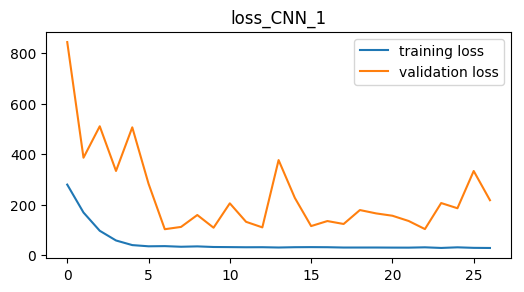

In [28]:
#CNN ResBlock1層による学習過程
import matplotlib.ticker as ticker

plt.figure(figsize=(6,3), dpi=100)

loss = history_CNN_1.history['loss']
val_loss = history_CNN_1.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, '-', label='training loss')
plt.plot(epochs, val_loss, '-', label='validation loss')
plt.title('loss_CNN_1')
plt.legend()
plt.savefig(save + 'loss_CNN_1')
plt.show()

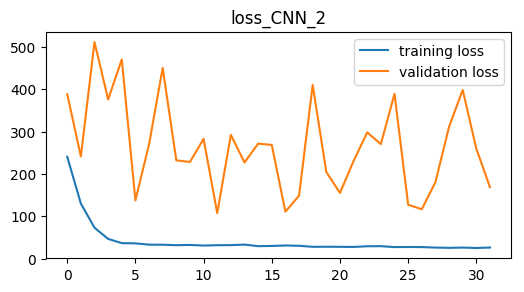

In [29]:
#CNN ResBlock2層による学習過程
import matplotlib.ticker as ticker

plt.figure(figsize=(6,3), dpi=100)

loss = history_CNN_2.history['loss']
val_loss = history_CNN_2.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, '-', label='training loss')
plt.plot(epochs, val_loss, '-', label='validation loss')
plt.title('loss_CNN_2')
plt.legend()
plt.savefig(save + 'loss_CNN_2')
plt.show()

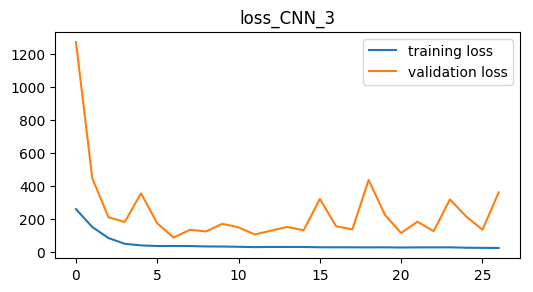

In [30]:
#CNN ResBlock3層による学習過程
import matplotlib.ticker as ticker

plt.figure(figsize=(6,3), dpi=100)

loss = history_CNN_3.history['loss']
val_loss = history_CNN_3.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, '-', label='training loss')
plt.plot(epochs, val_loss, '-', label='validation loss')
plt.title('loss_CNN_3')
plt.legend()
plt.savefig(save + 'loss_CNN_3')
plt.show()

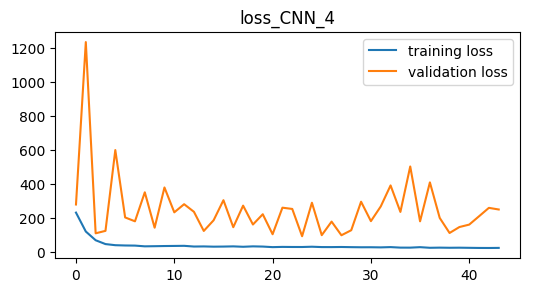

In [31]:
#CNN ResBlock4層による学習過程
import matplotlib.ticker as ticker

plt.figure(figsize=(6,3), dpi=100)

loss = history_CNN_4.history['loss']
val_loss = history_CNN_4.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, '-', label='training loss')
plt.plot(epochs, val_loss, '-', label='validation loss')
plt.title('loss_CNN_4')
plt.legend()
plt.savefig(save + 'loss_CNN_4')
plt.show()

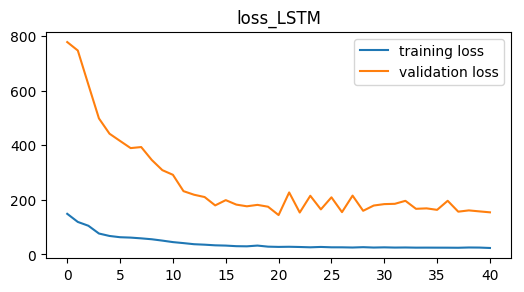

In [32]:
#LSTMによる学習過程
plt.figure(figsize=(6,3), dpi=100)

loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, '-', label='training loss')
plt.plot(epochs, val_loss, '-', label='validation loss')
plt.title('loss_LSTM')
plt.legend()
plt.savefig(save + 'loss_LSTM')
plt.show()

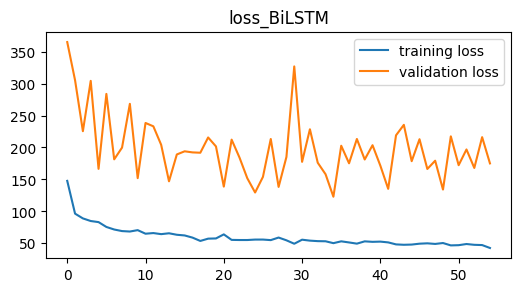

In [33]:
#BiLSTMによる学習過程
plt.figure(figsize=(6,3), dpi=100)

loss = history_BiLSTM.history['loss']
val_loss = history_BiLSTM.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, '-', label='training loss')
plt.plot(epochs, val_loss, '-', label='validation loss')
plt.title('loss_BiLSTM')
plt.legend()
plt.savefig(save + 'loss_BiLSTM')
plt.show()

In [34]:
#予測
pred_CNN_1 = model_CNN_1.predict(x_test)
pred_CNN_2 = model_CNN_2.predict(x_test)
pred_CNN_3 = model_CNN_3.predict(x_test)
pred_CNN_4 = model_CNN_4.predict(x_test)
pred_LSTM = model_LSTM.predict(x_test)
pred_BiLSTM = model_BiLSTM.predict(x_test)
#pred_ensemble = (pred_CNN_3 + pred_LSTM) / 2
#pred_ensemble2 = (pred_CNN _3+ pred_LSTM + pred_BiLSTM) / 3

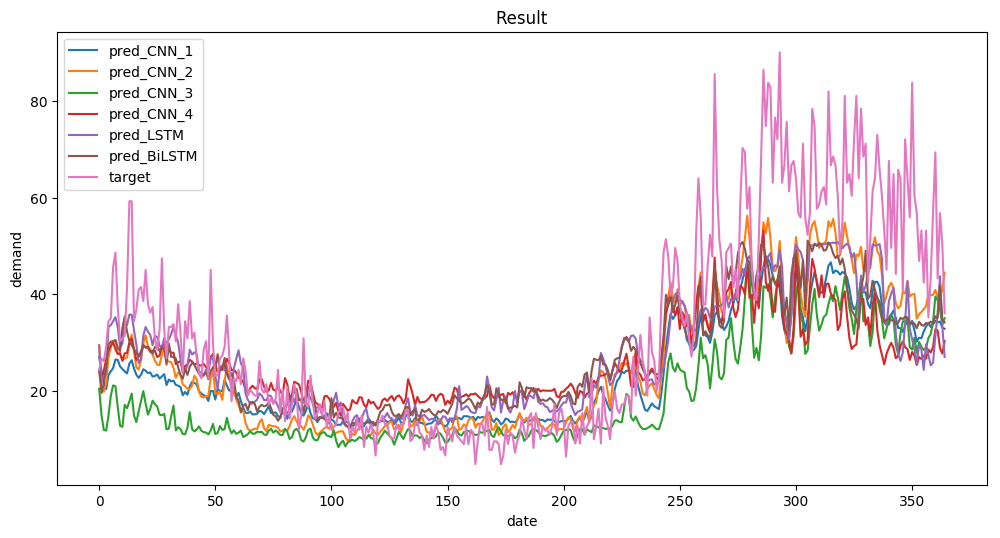

In [35]:
#予測結果の確認
%matplotlib inline

plt.figure(figsize=(12,6), dpi=100)
plt.plot(pred_CNN_1, '-', label='pred_CNN_1')
plt.plot(pred_CNN_2, '-', label='pred_CNN_2')
plt.plot(pred_CNN_3, '-', label='pred_CNN_3')
plt.plot(pred_CNN_4, '-', label='pred_CNN_4')
plt.plot(pred_LSTM, '-', label='pred_LSTM')
plt.plot(pred_BiLSTM, '-', label='pred_BiLSTM')
#plt.plot(pred_ensemble, '-', label='pred_ensemble')
#plt.plot(pred_ensemble2, '-', label='pred_ensemble2')
plt.plot(y_test, '-', label='target')
plt.title('Result')
plt.xlabel('date')
plt.ylabel('demand')
plt.legend()
plt.savefig(save + 'Result')
plt.show()

In [36]:
#平均平方2乗誤差（RMSE）の比較
from sklearn.metrics import mean_squared_error

rmse_CNN_1 = np.sqrt(mean_squared_error(y_test, pred_CNN_1))
rmse_CNN_2 = np.sqrt(mean_squared_error(y_test, pred_CNN_2))
rmse_CNN_3 = np.sqrt(mean_squared_error(y_test, pred_CNN_3))
rmse_CNN_4 = np.sqrt(mean_squared_error(y_test, pred_CNN_4))
rmse_LSTM = np.sqrt(mean_squared_error(y_test, pred_LSTM))
rmse_BiLSTM = np.sqrt(mean_squared_error(y_test, pred_BiLSTM))

max = np.array([rmse_CNN_1, rmse_CNN_2, rmse_CNN_3, rmse_CNN_4]).argmax()

pred_CNN_max = pred_CNN_1
if max == 1:
    pred_CNN_max = pred_CNN_2
elif max == 2:
    pred_CNN_max = pred_CNN_3
elif max == 3:
    pred_CNN_max = pred_CNN_4

rmse_ensemble = np.sqrt(mean_squared_error(y_test, (pred_CNN_max + pred_LSTM)/2))
rmse_ensemble2 = np.sqrt(mean_squared_error(y_test, (pred_CNN_max + pred_LSTM + pred_BiLSTM)/3))
rmse_average = (rmse_CNN_1 + rmse_CNN_2 + rmse_CNN_3 + rmse_CNN_4 + rmse_LSTM + rmse_BiLSTM + rmse_ensemble + rmse_ensemble2)/8
print('rmse_CNN_1 = {:.2f}, rmse_CNN_2 = {:.2f}, rmse_CNN_3 = {:.2f}, rmse_CNN_4 = {:.2f}, rmse_LSTM = {:.2f}, rmse_BiLSTM = {:.2f}, rmse_ensemble = {:.2f}, rmse_ensemble2 = {:.2f}, rmse_average = {:.2f}'.format(rmse_CNN_1, rmse_CNN_2, rmse_CNN_3, rmse_CNN_4, rmse_LSTM, rmse_BiLSTM, rmse_ensemble, rmse_ensemble2, rmse_average))

rmse_CNN_1 = 14.98, rmse_CNN_2 = 12.08, rmse_CNN_3 = 18.33, rmse_CNN_4 = 16.27, rmse_LSTM = 13.42, rmse_BiLSTM = 13.79, rmse_ensemble = 15.28, rmse_ensemble2 = 14.59, rmse_average = 14.84


In [37]:
print('{:.2f},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}'.format(rmse_CNN_1, rmse_CNN_2, rmse_CNN_3, rmse_CNN_4, rmse_LSTM, rmse_BiLSTM, rmse_ensemble, rmse_ensemble2, rmse_average))

14.98,12.08,18.33,16.27,13.42,13.79,15.28,14.59,14.84
